In [36]:
import pandas as pd
from ast import literal_eval

In [37]:
class ProximalCues:
    def __init__(self):
        generic = lambda x: literal_eval(x)

        conv = {'pc': generic}

        self.urls = pd.read_csv("../data/urls/url-reference_new.csv", converters=conv)

    # Get the proximal cues by page id
    def get_proximal_cues_by_id(self, id):
        return self.urls.loc[self.urls.id==id].pc.iloc[0]

In [38]:
import numpy as np


class TfIdf:
    def __init__(self):
        # Loading in the tf-idf
        # Rows are documents, the first column is the document id
        # Columns are keywords, the first row is the keyword id
        self.tfidf = pd.read_csv("../data/tf_idf/tf_idf.csv")

        # Loading in the keywords
        # Two columns, column 1 is id, column 2 is keyword
        # We can access the weight in the tf-idf by first accessing the id number from the keyword file
        self.tfidf_keywords = pd.read_csv("../data/tf_idf/tf_idf_keywords.csv")
        self.tfidf_keywords.columns = ["id", "keyword"]

    def get_id_by_keyword(self, keyword):
        return self.tfidf_keywords.id.iloc[self.tfidf_keywords[self.tfidf_keywords.keyword == keyword].index].values[0]


    def get_keyword_by_id(self, id):
        return self.tfidf_keywords.loc[self.tfidf_keywords.id==id, 'keyword'].iloc[0]
    # Method to get the tfidf value of a keyword in a page
    def get_tf_idf_value(self, page_id, keyword):
        keyword_id = self.get_id_by_keyword(keyword)
        return self.tfidf.iloc[page_id, keyword_id + 1]

    def get_all_keywords_by_id(self, page_id):
        keywords = self.tfidf.iloc[page_id][1:].values
        return keywords

    def get_all_keywords_by_id_normalized(self, page_id):
        keywords_weights = self.get_all_keywords_by_id(page_id)
        sum_value = sum(keywords_weights)
        keywords_weights_normalized = keywords_weights/sum_value
        return keywords_weights_normalized

    def get_number_of_keywords(self):
        return self.tfidf_keywords.shape[0]

In [39]:
class AdjacencyMatrix:
    def __init__(self):
        # Loading in the adjacency matrix
        # First column and row are data immediately, so access directly by page id
        # If row(page_id_1) leads to column(page_id_2) = 1 else = 0
        self.adjacency_matrix = pd.read_csv("../data/matrices/adjacency_matrix.csv", header=None)

    # Method to get the adjacency value from two page ids
    def get_adjacency_value(self, page_id_1, page_id_2):
        return self.adjacency_matrix.iloc[page_id_1, page_id_2] == 1

In [40]:
adjacency_matrix = AdjacencyMatrix()
proximal_cues = ProximalCues()
tfidf = TfIdf()

In [41]:
generic = lambda x: literal_eval(x)

conv = {'url_id_path': generic,
        'seconds_spent_path': generic}
df = pd.read_csv('../data/clickdata/dataNoUnscrapedVisitsOrUnder20Sec.csv', converters=conv)

paths = df.url_id_path
seconds = df.seconds_spent_path

I took the liberty to implement my own - perhaps but not necessarily slightly simplified - version of IUNIS.

Input is the ordered list of page id's that the user has visited.
For each page, take the TF-IDF values from that page, which is a row of keywords, with either 0 if the keyword is not present or 0<value<=1 if it is.

Then, for each next page, we add the TF-IDF values onto the existing weights.

Eventually we can sort the list and we will have the keywords with the highest weight on top.

In [64]:
from pandas import DataFrame
def find_keyword_weights(path, sorted):
    weights = np.zeros(tfidf.get_number_of_keywords())
    pd.options.display.max_rows = 0
    for id in path:
        weights += tfidf.get_all_keywords_by_id_normalized(id)
        weights /= max(weights)
    if sorted:
        df = DataFrame(weights, columns=['weights'])
        return df.sort_values(by=['weights'], ascending=False)
    return weights

In this model, I introduced a factor of decay. Essentially, every iteration, all values are divided by 1.25, meaning that recent keywords are more biased.
This is a very simple implementation, we can experiment with changing this 1.25, and also look at different implementations.

In [96]:
def find_keyword_weights_more_weight_on_recent_pages(path, decay_factor, sorted):
    weights = np.zeros(tfidf.get_number_of_keywords())
    pd.options.display.max_rows = 0
    for id in path:
        weights = weights/decay_factor
        weights += tfidf.get_all_keywords_by_id_normalized(id)
        weights /= max(weights)
    if sorted:
        df = DataFrame(weights, columns=['weights'])
        return df.sort_values(by=['weights'], ascending=False)
    return weights

This is a method to print out the top 'num_of_words' weighted keywords.

In [44]:
def print_top_weights_as_words(num_of_words, weights):
    top_weights = weights.head(num_of_words)
    i=0
    for index in top_weights.index:
        print(str(tfidf.get_keyword_by_id(index)) + " : " + str(top_weights.weights.iloc[i]))
        i+=1
    print("\n")

Line 2 in this section gets rid of all useless pages (login, logout, search, and error)
Then, if the user has visited more than 5 pages, it will compute the keywords up until page 5.

In [51]:
def remove_keywordless_pages(path, seconds):
    indices_to_remove = []
    for i in range(len(path)):
        if path[i]>1555:
            indices_to_remove.append(i)
    for i in range(len(indices_to_remove)-1, -1, -1):
        index = indices_to_remove[i]
        path.pop(index)
        seconds.pop(index)
    return path, seconds

These sections computes the weights after each different page to see how it changes throughout the visit
We can do interesting experiments to see how information need changes throughout the visit, and to find out at which page index we can best make our prediction final

In [46]:
path = paths[12]
path[:] = [x for x in path if x < 1556]
print(path)

[188, 228, 3, 1, 12, 7, 20, 1, 7, 1, 12, 7, 13, 188, 1]


In [47]:
for i in range(len(path)):
    subpath = path[:i+1]
    weights = find_keyword_weights_more_weight_on_recent_pages(subpath)
    print_top_weights_as_words(10, weights)

bijverdienen : 1.0
gekregen : 0.875277017645266
jaaropgave : 0.8620659396774324
betaalspecificatie : 0.8205906418828691
nabetaling : 0.7961984147428294
buitenland : 0.5409923820516527
dekkingsgraad : 0.4982173030124242
speciaal : 0.4324878278328123
uitbetaling : 0.43123633353548013
betaaldatums : 0.3672792338716384


bijverdienen : 1.0
gekregen : 0.8752770176452659
jaaropgave : 0.8620659396774324
betaalspecificatie : 0.8205906418828691
nabetaling : 0.7961984147428294
buitenland : 0.5409923820516527
dekkingsgraad : 0.4982173030124241
speciaal : 0.4324878278328123
uitbetaling : 0.4312363335354801
nabestaandenpensioen : 0.4060847339908747


bijverdienen : 1.0
gekregen : 0.8752770176452659
jaaropgave : 0.8620659396774324
betaalspecificatie : 0.8205906418828691
nabetaling : 0.7961984147428294
buitenland : 0.5409923820516527
dekkingsgraad : 0.4982173030124241
nabestaandenpensioen : 0.46733573618596824
speciaal : 0.4324878278328123
uitbetaling : 0.43123633353548


bijverdienen : 1.0
gekregen 

Idea for evaluation:

Look at the keywords at a specific time (we must make sure the weights are normalised, they are not in the implementation above), and compare it with a certain page near the end of the user visit to see if the user found their need.
We can do either the last page, or maybe the page that the user has spent the most time on.
The problem becomes that we want to evaluate the prediction of the information need, and there will be inaccuracies as the user data is not necessarily correct.
But if we can create a metric and we can compare different implementations with the same metric we still have something nice.


In [89]:
import math


def estimate_most_important_page(path, seconds):
    path = path[int(len(path)/2):]
    seconds = seconds[int(len(seconds)/2):]
    index = seconds.index(max(seconds))
    return path[index]

def find_keywords_of_estimated_most_important_page(path, seconds):
    id = estimate_most_important_page(path, seconds)
    return tfidf.get_all_keywords_by_id_normalized(id)

from numpy import dot
from numpy.linalg import norm
def similarity_estimated_information_need(information_need, keywords_most_important_page):
    def cosine_similarity(list_1, list_2):
        cos_sim = dot(list_1, list_2) / (norm(list_1) * norm(list_2))
        return cos_sim
    similarity = cosine_similarity(information_need, keywords_most_important_page)
    if math.isnan(similarity):
        return 0
    return similarity

In [90]:
def compute_similarities(subpath_size):
    count=0
    similarity_list = []
    for j in range(len(paths)):
        path, second = remove_keywordless_pages(paths[j], seconds[j])
        if count == 1000:
            break
        if len(path)>6:
            count+=1
            subpath = path[:subpath_size]
            weights = find_keyword_weights(subpath, False)
            similarity_list.append(similarity_estimated_information_need(weights, find_keywords_of_estimated_most_important_page(path, second)))
    return similarity_list

In [91]:
similarity_list_1 = compute_similarities(1)
similarity_list_2 = compute_similarities(2)
similarity_list_3 = compute_similarities(3)
similarity_list_4 = compute_similarities(4)
similarity_list_5 = compute_similarities(5)

C:\Users\01din\AppData\Local\Temp\ipykernel_27224\2417980606.py:35: RuntimeWarning: invalid value encountered in true_divide
  keywords_weights_normalized = keywords_weights/sum_value


In [95]:
print(np.mean(similarity_list_1))
print(np.mean(similarity_list_2))
print(np.mean(similarity_list_3))
print(np.mean(similarity_list_4))
print(np.mean(similarity_list_5))

0.06827919047832111
0.08763027893702857
0.10729567178250851
0.1444066589297204
0.17566170221336747


In [125]:
def compute_similarities_decay(decay_factor):
    count=0
    similarity_list = []
    for j in range(len(paths)):
        path, second = remove_keywordless_pages(paths[j], seconds[j])
        if count == 1000:
            break
        if len(path)>6:
            count+=1
            subpath = path[:3]
            weights = find_keyword_weights_more_weight_on_recent_pages(subpath, decay_factor, False)
            similarity_list.append(similarity_estimated_information_need(weights, find_keywords_of_estimated_most_important_page(path, second)))
    return similarity_list

In [112]:
avg_sim_list = []

for i in range(1,51):
    similarity_list = compute_similarities_decay(i)
    avg_sim_list.append(np.mean(similarity_list))

C:\Users\01din\AppData\Local\Temp\ipykernel_27224\2417980606.py:35: RuntimeWarning: invalid value encountered in true_divide
  keywords_weights_normalized = keywords_weights/sum_value


In [113]:
avg_sim_list

[0.11406294830471776,
 0.13815981276942568,
 0.1525111131936669,
 0.15984123068723938,
 0.1633624105855915,
 0.1648101384056773,
 0.16510022545344458,
 0.1647560534313497,
 0.1641696493063086,
 0.1636150564256052,
 0.1629073659661259,
 0.16208566827736165,
 0.16124008764274808,
 0.16038201853474557,
 0.15953501827406444,
 0.1587139852883536,
 0.15791039948425087,
 0.1571880497701824,
 0.156491739657473,
 0.1558239287196317,
 0.15518277417146897,
 0.1545680671829046,
 0.15397779185956773,
 0.15341117881305902,
 0.15286920779749277,
 0.1523180544582849,
 0.15179044599924224,
 0.15128920061839363,
 0.1508094458474127,
 0.15035108571992314,
 0.14991319318054935,
 0.1494946789705611,
 0.1490945965136794,
 0.1487130258984474,
 0.14834818762222016,
 0.14799865656976766,
 0.1476635866471548,
 0.1473421430346586,
 0.14703314664418177,
 0.14673724621397963,
 0.14645494650171148,
 0.14618299433259324,
 0.14591891673290358,
 0.14566170525551572,
 0.14541197564571892,
 0.1451682920436345,
 0.144933

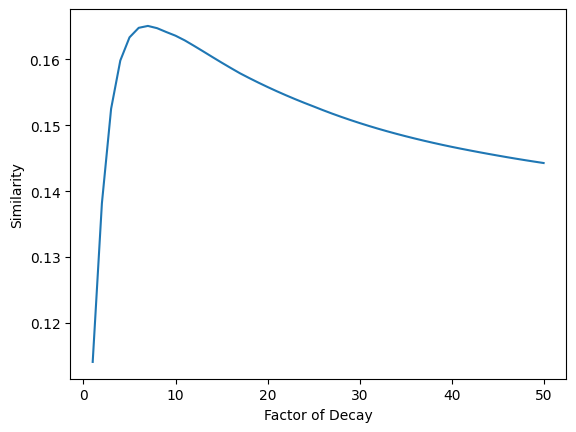

In [129]:
from matplotlib import pyplot as plt
plt.plot(list(range(1,51)), avg_sim_list)
plt.xlabel("Factor of Decay")
plt.ylabel("Similarity")
plt.show()

In [126]:
avg_sim_list_no_decay =[]

for i in range(1,8):
    similarity_list = compute_similarities(i)
    avg_sim_list_no_decay.append(np.mean(similarity_list))

C:\Users\01din\AppData\Local\Temp\ipykernel_27224\2417980606.py:35: RuntimeWarning: invalid value encountered in true_divide
  keywords_weights_normalized = keywords_weights/sum_value


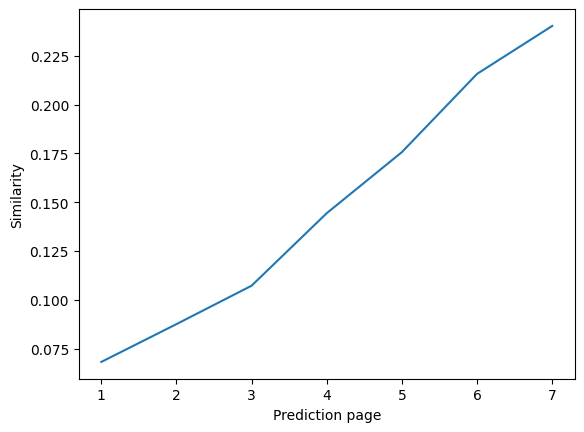

In [128]:
plt.plot(list(range(1,8)), avg_sim_list_no_decay)
plt.xlabel("Prediction page")
plt.ylabel("Similarity")
plt.show()